In [1]:
%pylab inline 
from bigfile import BigFile  
import seaborn as sns
import scipy.interpolate as interpolate
from matplotlib.colors import ListedColormap
from scipy.interpolate import interp1d

from scipy import integrate
from gaepsi2 import painter
from gaepsi2 import color
from gaepsi2 import camera
from scipy.spatial import cKDTree as KDTree

import matplotlib.patches as patches

import pickle

import import_ipynb
import Low_Redshift_Tuple_IDs as tuples

Populating the interactive namespace from numpy and matplotlib
importing Jupyter notebook from Low Redshift Tuple IDs.ipynb
Number of triples: 553
Number of quadruples: 64


In [2]:
triples = tuples.z1_triples
quadruples = tuples.z1_quadruples

In [3]:
import warnings
warnings.filterwarnings("ignore")

sns.set_palette(sns.set_style("white"),\
                sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"}))

In [4]:
plt.rcParams['axes.linewidth'] = 1.8 #set the value globally
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 18
plt.rc('xtick', labelsize=17)    # fontsize of the tick labels
plt.rc('ytick', labelsize=17) 

In [5]:
import matplotlib as mpl
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = mpl.cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

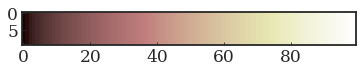

In [6]:
y = np.linspace(0,1,100)
COL = MplColorHelper('pink', 0, 1)

x = COL.get_rgb(y)
starmap = color.Colormap(x[:,0:3])

#----
z = np.expand_dims(x,axis=0)
z = np.repeat(z,10,axis=0)
plt.imshow(z)

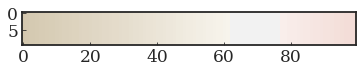

In [7]:
class MplColorHelper2:
    def __init__(self, cmap, start_val, stop_val):
        self.cmap = cmap
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = mpl.cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)
    
y = np.linspace(0,1,100)
COL = MplColorHelper2(sns.diverging_palette(60, 20, as_cmap=True), -1.2, 2.6)
x = COL.get_rgb(y)
starmap = color.Colormap(x[:,0:3])
z = np.expand_dims(x,axis=0)
z = np.repeat(z,10,axis=0)
plt.imshow(z)

In [8]:
hh = 0.697

fac = 121.14740013761634  # GADGET unit Protonmass / Bolztman const
GAMMA = 5 / 3.
Xh=0.76

Mpc_to_km=3.086e+19
sec_to_megayr=3.17098e-8 # convert to years

omk=0
oml=0.7186
omm=0.2814
h=hh=0.697

def E(a): #normalized hubble parameter
    return np.sqrt(omm*(a)**(-3)+oml)

def integrand(a):
    return 1.0/(a*E(a))

def age(a0,a1):
    return 1./(h*100.0)*integrate.quad(integrand,a0,a1)[0]

def smooth(pos):
    tree = KDTree(pos)
    d, i = tree.query(pos,k=60)
    return d[:,-1].copy()

In [9]:
def inertia(pos,mass):  # pos in [[x1,x2..],[y1,y2..],[z1,z2..]]
    g11=np.sum((pos[1]*pos[1]+pos[2]*pos[2])*mass)
    g22=np.sum((pos[0]*pos[0]+pos[2]*pos[2])*mass)
    g33=np.sum((pos[0]*pos[0]+pos[1]*pos[1])*mass)
    g12=-np.sum(pos[0]*pos[1]*mass)
    g13=-np.sum(pos[0]*pos[2]*mass)
    g23=-np.sum(pos[1]*pos[2]*mass)
    g21=g12
    g31=g13
    g32=g23
    mx = np.array([[g11,g12,g13],[g21,g22,g23],[g31,g32,g33]])/np.sum(mass)
    w, v = np.linalg.eig(mx)
    v = v[:, np.abs(w).argsort()] # column v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
    return v                      # return Imom eigenvector with eigenvalue from smallest to largest

def face_on_3rotate(dr,mass,th=-1): # p in [[x1,y1,z1],[x2,y2,z2],...]
    rr = np.linalg.norm(dr,axis=1)
    if th>0:
        mask = rr<th
    else:
        mask = rr>0
    v = inertia(np.transpose(dr[mask]),mass[mask])
#     print (v)
    xnew = np.einsum('ij,j->i', dr, v[:,0])
    ynew = np.einsum('ij,j->i', dr, v[:,1])
    znew = np.einsum('ij,j->i', dr, v[:,2])
    newpos = np.transpose(np.array([xnew,ynew,znew]))
    return newpos

def edge_on_3rotate(dr,mass,th=-1): # p in [[x1,y1,z1],[x2,y2,z2],...]
    rr = np.linalg.norm(dr,axis=1)
    if th>0:
        mask = rr<th
    else:
        mask = rr>0
    v = inertia(np.transpose(dr[mask]),mass[mask])
#     print ("rotate axis:",v)
    xnew = np.einsum('ij,j->i', dr, v[:,1])
    ynew = np.einsum('ij,j->i', dr, v[:,2])
    znew = np.einsum('ij,j->i', dr, v[:,0])
    newpos = np.transpose(np.array([xnew,ynew,znew]))
    return newpos

In [10]:
def calc_pos2(bh,z,fv='extrapolate',kind = 'linear'):
    fx = interp1d(bh['z'],bh['BHpos'][:,0],fill_value=fv,kind = kind)
    fy = interp1d(bh['z'],bh['BHpos'][:,1],fill_value=fv,kind = kind)
    fz = interp1d(bh['z'],bh['BHpos'][:,2],fill_value=fv,kind = kind)
    return np.array([fx(z),fy(z),fz(z)])

In [11]:
def place(number, offarray):   # offarray is sorted from smallest to largest 
    dummy = np.where(offarray <= number)[0]
    return dummy[-1]

In [12]:
path = '/hildafs/datasets/Asterix/BH_details_dict/Read-Blackhole-Detail'
detail = BigFile(path)
AllIDs = detail.open('BHID')[:]
Index = detail.open('Index')[:]

In [13]:
outdir = '/hildafs/datasets/Asterix/BH_details_dict/'

In [14]:
def triple_idx (trips):
    length = len (trips)
    ret_val = []
    
    BH_IDs = pig.open('5/ID')[:1000000]
    
    for i in range (length):
        curr = trips[i]
        
        idx1 = (BH_IDs == curr[0]).nonzero()[0][0]
        idx2 = (BH_IDs == curr[1]).nonzero()[0][0]
        idx3 = (BH_IDs == curr[2]).nonzero()[0][0]
        
        ret_val.append([idx1, idx2, idx3])
        
    return ret_val

In [15]:
def trip_com (tripindex, weighted=True):
    bh1idx = tripindex[0]
    bh2idx = tripindex[1]
    bh3idx = tripindex[2]
    
    bh1pos = pig.open('5/Position')[bh1idx]
    bh2pos = pig.open('5/Position')[bh2idx]
    bh3pos = pig.open('5/Position')[bh3idx]
    
    if weighted:
        bh1mass = pig.open('5/BlackholeMass')[bh1idx]
        bh2mass = pig.open('5/BlackholeMass')[bh2idx]
        bh3mass = pig.open('5/BlackholeMass')[bh3idx]
    else:
        bh1mass, bh2mass, bh3mass = 1,1,1
    
    totmass = bh1mass + bh2mass + bh3mass
    
    xcm = ((bh1mass * bh1pos[0]) + (bh2mass * bh2pos[0]) + (bh3mass * bh3pos[0])) / totmass
    ycm = ((bh1mass * bh1pos[1]) + (bh2mass * bh2pos[1]) + (bh3mass * bh3pos[1])) / totmass
    zcm = ((bh1mass * bh1pos[2]) + (bh2mass * bh2pos[2]) + (bh3mass * bh3pos[2])) / totmass
    
    return array([xcm, ycm, zcm])

In [16]:
def extract_host_galaxies_triples(pig,frame,trip,tripindex,groupindex,crop=20,orientation='None',ort_radius=-1):
    redshift = 1./pig.open('Header').attrs['Time']-1
    # print ("z = ",redshift)
    
    a_cur=1./(1.+redshift)
    SFT_space=np.linspace(0,a_cur[0],500)
    age_space=[age(SFT,1./(1.+redshift))*Mpc_to_km*sec_to_megayr for SFT in SFT_space]  # age in year
    gen_SFT_to_age=interpolate.interp1d(SFT_space,age_space,fill_value='extrapolate')
    
    bh1idx = tripindex[0]
    bh2idx = tripindex[1]
    bh3idx = tripindex[2]
    
    bh1pos = pig.open('5/Position')[bh1idx]
    bh2pos = pig.open('5/Position')[bh2idx]
    bh3pos = pig.open('5/Position')[bh3idx]
    # print ("bh position:", bhpos)

        
    if frame == 'COM':
        COMpos = trip_com (tripindex)
    elif frame == 'Center':
        COMpos = trip_com (tripindex, weighted=False)
    
    BHLength = pig.open('FOFGroups/LengthByType')[0:10000]
    off = np.cumsum(BHLength,axis=0)
    a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
    off = np.append(a1,off,axis=0)    # This is OffsetByType of FOF group
    
    staroff = np.transpose(off[groupindex:groupindex+2])[4]
 
    #######################################################################################
    
    pos4 = pig.open('4/Position')[staroff[0]:staroff[1]]
    ppos = pos4 - COMpos
    
    # crop was originally 20; trips defined by separation of 30 kpc, start with crop = 30
    
    mask = np.abs(ppos[:,0]) < crop
    mask &= np.abs(ppos[:,1]) < crop
    mask &= np.abs(ppos[:,2]) < crop
    
    ppos = ppos[mask]
    
    m4 = pig.open('4/Mass')[staroff[0]:staroff[1]][mask]
    st = pig.open('4/StarFormationTime')[staroff[0]:staroff[1]][mask]
    star_age = gen_SFT_to_age(st)/1e6 # in Myr
    # print ("numer of stars:",len(m4))
    mstar = np.sum(m4)*1e10/hh
    # print ("stellar mass = %.2e"%mstar)
    
    if orientation is 'face_on':
        ppos = face_on_3rotate(ppos,m4,th=ort_radius)            
        
    if orientation is 'edge_on':
        ppos = edge_on_3rotate(ppos,m4,th=ort_radius)
    
    sml = smooth(ppos)  
    sml *= 1.6
    
    sml[sml>2] = 2
    # sml = np.ones(len(m4))*0.9
    
    #######################################################################################
    
    lbox = 2*crop
    # resolution = 0.12
    resolution = 0.6
    imsize = int(lbox/resolution)
    # print (imsize)
    if imsize>5000:
        imsize=5000

    ct = lbox/2

    mpers = camera.ortho(-lbox,lbox,(-ct,ct,-ct,ct))  # (near,far,(left,right,top,bottom)),return 4*4 projectionmatrix
    mmv = camera.lookat((0,0,2*lbox),(0,0,0),(1,0,0)) # (position of camera, focal point, up direction)
    star2d = camera.apply(camera.matrix(mpers,mmv),ppos) # apply a camera matrix to data coordinates, return position in clip coordinate
    stardev = camera.todevice(star2d, extent=(imsize, imsize)) # Convert clipping coordinate to device coordinate

    psml = sml/resolution
    psml[psml<1]=1
    
    channels = painter.paint(stardev, psml, [m4,m4*star_age], (imsize, imsize), np=8)
    channels[1] /= channels[0]
    
    return channels,mstar

In [17]:
def plot_trip(ax,bh1,bh2,bh3,bh_massive,trip,Lb,frame='COM'):
    tripidx = triple_idx([trip])[0]
    grpidx = place(tripidx[0],bhoff)
    # print ("groupindex:",grpidx)
    
    
    if frame == 'COM':
        COMpos = trip_com (tripidx)
    elif frame == 'Center':
        COMpos = trip_com (tripidx, weighted=False)
    
        print ("system com:",COMpos)
    
    sysm = 0
    
    redshift = 1./battr["Time"][0] - 1
    
    masses = []
    
    massive = 0
    
    for bidx in tripidx:
        bhm = pig.open('5/BlackholeMass')[bidx]*1e10/hh
        sysm += bhm
        masses.append(bhm)
        # print ("bh mass = %.2e"%bhm)
        bhpos = pig.open('5/Position')[bidx]
        
        if frame == '214' and bhm > massive:
            massive = bhm
            COMpos = bhpos
        # print ("bh pos = ",bhpos)
    
    # print("Triple:",trip)
    # print("BH Mass:",masses)
    
    #if redshift > 3.25:
    #    Lb = 250
    #else:
    #    Lb = 150
    crop1 = Lb/2
    channels,mstar = extract_host_galaxies_triples(pig,frame,trip,tripindex=tripidx,groupindex=grpidx,crop=crop1,ort_radius=4)
    vmin0,vmax0 = np.log10(np.percentile(channels[0],30)),np.log10(np.percentile(channels[0],99))
    # vmin1,vmax1 = (np.percentile(np.nan_to_num(channels[1]),30)),(np.percentile(np.nan_to_num(channels[1]),99))    
    img1 = starmap(color.NL(channels[1], range=(1,2.8)), color.NL(channels[0], range=(-4.5,vmax0)))
    
    """
    channels,mstar = extract_host_galaxies_triples(pig,tripindex=tripidx,groupindex=grpidx,orientation='edge_on',crop=30,ort_radius=4)
    vmin0,vmax0 = np.log10(np.percentile(channels[0],30)),np.log10(np.percentile(channels[0],99))
    img2 = starmap(color.NL(channels[1], range=(1,2.8)), color.NL(channels[0], range=(-4.5,vmax0)))    
    
    gsize = img1.shape[0]
    gstart,gend = int(gsize*0.3335),int(gsize*0.6665)
    img = np.concatenate([img1,img2[gstart:gend,:]],axis=0)
    """
    img = img1
    
    zmerge = redshift
    
    zz = np.linspace(zmerge,zmerge-0.5,1000)[::-1]

    bh1_pos = calc_pos2(bh1,zz)
    bh2_pos = calc_pos2(bh2,zz)
    bh3_pos = calc_pos2(bh3,zz)
    massive_pos = calc_pos2(bh_massive,zz)
    
    ax.imshow(img,extent=[0,Lb,0,Lb],origin='upper')
    
    # ax.scatter(Lb/2, 0.33*Lb + Lb/2,s=5)
    
    bh1pos = pig.open('5/Position')[tripidx[0]]
    bh2pos = pig.open('5/Position')[tripidx[1]]
    bh3pos = pig.open('5/Position')[tripidx[2]]
    
    # ax.scatter(Lb/2, Lb/2, marker='o', c='r')
    
    #ax.plot(bh1_pos[0,:]-massive_pos[0,:]+Lb/2,bh1_pos[1,:]-massive_pos[1,:]+Lb/2,c='m')
    #ax.plot(bh2_pos[0,:]-massive_pos[0,:]+Lb/2,bh2_pos[1,:]-massive_pos[1,:]+Lb/2,c='cyan')
    #ax.plot(bh3_pos[0,:]-massive_pos[0,:]+Lb/2,bh3_pos[1,:]-massive_pos[1,:]+Lb/2,c='orange')
    
    ax.plot(bh1_pos[0,:]-massive_pos[0,:]+Lb/2,bh1_pos[1,:]-massive_pos[1,:]+Lb/2,c='m',zorder=1)
    ax.plot(bh2_pos[0,:]-massive_pos[0,:]+Lb/2,bh2_pos[1,:]-massive_pos[1,:]+Lb/2,c='cyan',zorder=1)
    ax.plot(bh3_pos[0,:]-massive_pos[0,:]+Lb/2,bh3_pos[1,:]-massive_pos[1,:]+Lb/2,c='orange',zorder=1)
    
    ax.scatter((bh1pos[0]-COMpos[0]) + Lb/2, (bh1pos[1]-COMpos[1]) + Lb/2,s=100,marker='x', linewidth=4, c='m',zorder=2)
    ax.scatter((bh2pos[0]-COMpos[0]) + Lb/2, (bh2pos[1]-COMpos[1]) + Lb/2,s=100,marker='x',linewidth=4,c='cyan',zorder=2)
    ax.scatter((bh3pos[0]-COMpos[0]) + Lb/2, (bh3pos[1]-COMpos[1]) + Lb/2,s=100,marker='x',linewidth=4,c='orange',zorder=2)
        
    #ax.plot((bh1_x - COMpos[0]) + Lb/2, (bh1_y - COMpos[1]) + Lb/2,c='m')
    #ax.plot((bh2_x - COMpos[0]) + Lb/2, (bh2_y - COMpos[1]) + Lb/2,c='cyan')
    #ax.plot((bh3_x - COMpos[0]) + Lb/2, (bh3_y - COMpos[1]) + Lb/2,c='orange')
    
    xst = Lb*0.01
    yst = Lb*1.29
    lt = Lb*0.4
    
    # bhm0 = pig.open('5/BlackholeMass')[bidx]*1e10/hh

    # ax.annotate(s='',xy=(xst+lt,yst),xytext=(xst,yst),
    #             arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3',color='white',lw=2))
    # ax.text(Lb*0.05,yst-Lb*0.10,'8 ckpc/h',dict(color='white'),size=16)
    redshift = 1./pig.open('Header').attrs['Time']-1
    
    info = r'$z$=%d'%(round(redshift[0],2)) + '\ntriplet'
    ax.text(Lb*0.75,Lb*0.83,info,dict(color='white'),size=16)

    tcolor="white"
    info1 = r'$M_{\mathrm{BHx3}}$=%.1e$M_{\odot}$'%sysm
    info2 = r'$M_{*}$ = %.1e$M_{\odot}$'%mstar
    info = info1+info2
    #ax.text(Lb*0.05,Lb*0.15,info1,dict(color=tcolor),size=16)
    #ax.text(Lb*0.05,Lb*0.05,info2,dict(color=tcolor),size=16)
    
    ax.set_xlim(0,Lb)
    ax.set_ylim(0,Lb)
    ax.set_xticks([])
    ax.set_yticks([])

In [18]:
def get_bh_history(bhid):
    idx = (AllIDs==bhid).nonzero()[0][0]
    chunk = Index[idx]
    # print('File number of the target BHs:',chunk)
    # now load bh data
    outdir = '/hildafs/datasets/Asterix/BH_details_dict/'
    save = outdir+'BlackholeDetails-%04d'%chunk
    with open(save, 'rb') as f:
        data = pickle.load(f)
        f.close()
    bh = data[bhid]
    return bh

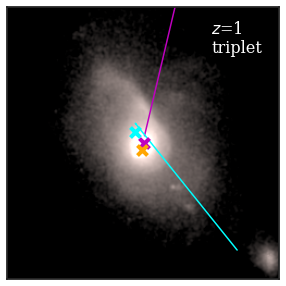

In [19]:
pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_483')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
hh = battr['HubbleParam']
    
DM_pos = pig.open('1/Position')

BH_IDs = pig.open('5/ID')[:]
lbt = pig.open('FOFGroups/LengthByType')[:]
OffsetByType = np.cumsum(lbt,axis=0)
a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
OffsetByType = np.append(a1,OffsetByType,axis=0)
bhoff = OffsetByType[:,5]

for triple in triples[149:150]:
    f,ax = plt.subplots(1,1,figsize=(5,5))
    f.subplots_adjust(hspace=0.03,wspace=0.03)
    
    id1, id2, id3 = triple

    bh1 = get_bh_history(id1)
    bh2 = get_bh_history(id2)
    bh3 = get_bh_history(id3)
    
    plot_trip(ax,bh1,bh2,bh3,bh3,trip=triple,Lb=150,frame='COM')
    
    del bh1
    del bh2
    del bh3